# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.

In [1]:
# Import some libs
import pandas
import numpy as np
from sklearn.model_selection import train_test_split

# Load amazon review dataset

In [2]:
# Import amazon_baby.csv data to pandas dataframe
products_df = pandas.read_csv('/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/data/amazon_baby.csv')# Extract word counts and sentiments

# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [3]:
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation)

products_df = products_df.fillna({'review':''})  # fill in N/A's in the review column
products_df['review_clean'] = products_df['review'].apply(remove_punctuation)

products_df = products_df[products_df['rating'] != 3]

products_df['sentiment'] = products_df['rating'].apply(lambda rating : +1 if rating > 3 else -1)# Extract word counts and sentimentsAs in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [4]:
np.random.seed(1)

train_data, test_data = train_test_split(products_df, test_size=0.2)

## Feature representation
 We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors.
<br>
You can checkout the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from scikit documentation.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train logistic regression model
Learn a logistic regression classifier using the training data. We are using scikit-learn, you should create an instance of the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (**train_matrix**) as features and the column **sentiment** of **train_data** as the target. Use the default values for other parameters.

In [6]:
from sklearn.linear_model import LogisticRegression

X, y = train_matrix, train_data['sentiment']
X_test, y_test = test_matrix, test_data['sentiment']

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
print('Train accuracy: {}'.format(clf.score(X, y)))
print('Test accuracy: {}'.format(clf.score(test_matrix, test_data['sentiment'])))

Train accuracy: 0.9474816530610715
Test accuracy: 0.9344247548799136


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [8]:
baseline = test_data[test_data['sentiment'] == 1].shape[0]/test_data.shape[0]
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8417438757458547


**Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?
<br>
**Your answer**:

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```

In [9]:
y_test_pred = clf.predict(X_test)

In [10]:
from sklearn.metrics import confusion_matrix

unique_label = [1, -1]
confusion = confusion_matrix(y_test, y_test_pred, labels=unique_label)
print(pandas.DataFrame(confusion, 
                       index=['true:{:}'.format(x) for x in unique_label], 
                       columns=['pred:{:}'.format(x) for x in unique_label]))

         pred:1  pred:-1
true:1    27324      749
true:-1    1438     3840


**Quiz Question**: How many predicted values in the **test set** are **false positives**?
<br>
**Your answer**: 1438

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?
<br>
**Your answer**:

In [11]:
FP, FN = confusion[1][0], confusion[0][1]
cost = 100*FP + 1*FN

print ("cost: {}$".format(cost))

cost: 144549$


## Precision and Recall
You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [12]:
from sklearn.metrics import precision_recall_fscore_support

results = precision_recall_fscore_support(y_test, y_test_pred, labels=[1, -1])

pricisions = results[0]

In [13]:
pricisions

array([0.95000348, 0.83678361])

**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)
<br>
**Your answer**:

In [ ]:
false_positives_per = FP / (FP + confusion[0][0])

print ('false positives percentage: {0:.2f}'.format(false_positives_per))

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [ ]:
recalls = results[1]
print (recalls)

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


In [14]:
def apply_threshold(probabilities, threshold):
    results = np.array(len(probabilities)*[1])
    results[probabilities > threshold] = 1
    results[probabilities <= threshold] = 0
    return results

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [15]:
probabilities = clf.predict_proba(X_test)[:, 0]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

print(predictions_with_default_threshold)
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

[0 0 0 ... 0 0 0]
Number of positive predicted reviews (threshold = 0.5): 4589
Number of positive predicted reviews (threshold = 0.9): 2529


## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [16]:
from sklearn.metrics import precision_recall_curve

thresold = [0.1, 0.5, 0.9]
precision, recall, _ = precision_recall_curve(y_test, probabilities)

(0.0, 1.0)

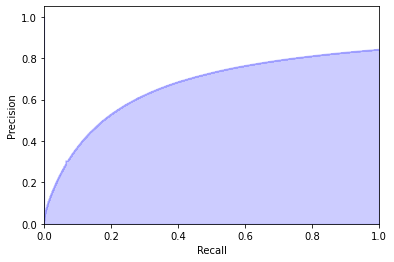

In [17]:
import matplotlib.pyplot as plt
from inspect import signature

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])